# preprocessing and training on a subset of the dataset

In [3]:
import pandas as pd
import shutil
import random
from DicomRTTool.ReaderWriter import DicomReaderWriter, ROIAssociationClass
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, TensorDataset
import pickle
import json
import torch.nn.functional as F
import tqdm

## Train/dev/test split

In [2]:
positive_folder = r'/home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive'
negative_folder = r'/home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative'

# Load the data and labels
positive_data = [os.path.join(positive_folder, filename) for filename in os.listdir(positive_folder)]
negative_data = [os.path.join(negative_folder, filename) for filename in os.listdir(negative_folder)]
data = positive_data + negative_data
labels = [1] * len(positive_data) + [0] * len(negative_data)

# Shuffle the data and labels together
combined_data = list(zip(data, labels))
random.shuffle(combined_data)
data, labels = zip(*combined_data)

# Determine the sizes of each set
train_size = int(0.7 * len(data))
dev_size = int(0.15 * len(data))

# Split the data into train, dev, and test sets
train_data, remaining_data, train_labels, remaining_labels = train_test_split(data, labels, train_size=train_size, stratify=labels)
dev_data, test_data, dev_labels, test_labels = train_test_split(remaining_data, remaining_labels, train_size=dev_size/(len(data)-train_size), stratify=remaining_labels)

# Print the sizes of each set
print(f"Train set size: {len(train_data)}")
print(f"Dev set size: {len(dev_data)}")
print(f"Test set size: {len(test_data)}")



Train set size: 136
Dev set size: 29
Test set size: 30


In [72]:
path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/train_dev_test_lists'

In [14]:
with open(os.path.join(path, "train_data.json"), "w") as file:
    json.dump(train_data, file)

with open(os.path.join(path, "train_labels.json"), "w") as file:
    json.dump(train_labels, file)

with open(os.path.join(path, "dev_data.json"), "w") as file:
    json.dump(dev_data, file)

with open(os.path.join(path, "dev_labels.json"), "w") as file:
    json.dump(dev_labels, file)

with open(os.path.join(path, "test_data.json"), "w") as file:
    json.dump(test_data, file)

with open(os.path.join(path, "test_labels.json"), "w") as file:
    json.dump(test_labels, file)

In [6]:
with open(os.path.join(path, "train_data.json"), "r") as file:
    train_data = json.load(file)

with open(os.path.join(path, "train_labels.json"), "r") as file:
    train_labels = json.load(file)

## Create Dataset

### Initial approach

In [3]:
class CTMaskDataset(Dataset):
    def __init__(self, ct_path, label, desired_num_slices=200):
        self.ct_path = ct_path
        self.label = label
        self.desired_num_slices= desired_num_slices

        self.Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        self.Dicom_reader.walk_through_folders(ct_path)

        Contour_names = ['lung'] # Define what rois you want
        associations = [ROIAssociationClass('lung', ['lungs', 'whole lung'])] 
        self.Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)

        self.indexes = self.Dicom_reader.which_indexes_have_all_rois()

    def __len__(self):
        return len(self.indexes)
    
    def pad_tensor(self, data):
        # Calculate padding
        diff = self.desired_num_slices - data.shape[0]
        # Check if we need padding
        if diff > 0:
            # Apply padding
            data = np.pad(data, ((0, diff), (0, 0), (0, 0)))
        else:
            # Truncate
            data = data[:self.desired_num_slices]
        return data


    def __getitem__(self, idx):

        pt_indx = self.indexes[idx]
        print('index type: ', type(pt_indx))
        
        self.Dicom_reader.set_index(pt_indx)  
        self.Dicom_reader.get_images_and_mask()  # Load up the images and mask for the requested index

        image = self.Dicom_reader.ArrayDicom # image array
        mask = self.Dicom_reader.mask # mask array

      
        image = image.astype(float)
        image /= image.max()

        mask = (mask > 0).astype(int)

        image = self.pad_tensor(image)
        mask = self.pad_tensor(mask)

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)
        label = torch.tensor(self.label, dtype=torch.long)

        return image, mask, label

In [4]:
dataset = CTMaskDataset(train_data[0], train_labels[0])
idx = 1
while idx < 2:
    try:
        next_dataset = CTMaskDataset(train_data[idx], train_labels[idx])
        dataset = ConcatDataset([dataset, next_dataset])
    except TypeError:
        print("skip this dataset")
        continue
    idx += 1

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.65s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 1, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Contour names or associations changed, resetting mask
The following indexes hav

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.59s/it]

Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050. Found ['r lung', 'b plex', 'cord', 'gtv free', 'outer contour', 'trach', 'gtv ex', 'combo lungs', 'eso', 'prox bronch', 'gtv in', 'heart', 'itv', 'gtv in gtv ex union', 'left l

In [5]:
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

### Numpy approach

In [7]:
## set number of skipped slices
skip = 4

#### Finding all whole lung labels

In [18]:
lung_list = ['both lungs', 'lung_whole', 'total lung', 'combo lung', 'combined lung', 'whole lung', 'lungs', 'whole_lung', 'composite lung', 'combo lungs']
missing_lungs = 0

roi_names = []
for i in range(len(train_data)):
    Dicom_path = train_data[i]
    Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
    Dicom_reader.walk_through_folders(Dicom_path) 
    # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present
    # roi_names = roi_names.union(set(all_rois))
    Contour_names = ['lung'] 
    associations = [ROIAssociationClass('lung', lung_list)]
    Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
    indexes = Dicom_reader.which_indexes_have_all_rois()
    if indexes==[]:
        all_rois = Dicom_reader.return_rois(print_rois=True)
        roi_names.append('new')
        roi_names.append(all_rois)
        missing_lungs += 1

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.01s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 1, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Contour names or associations changed, resetting mask
The following indexes hav

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.97s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.86s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.82s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 4, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670. Found []
Lacking ['lung'] in index 2, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [01:09<00:00, 69.02s/it]


Compiling dictionaries together...
Index 0, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 4, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 8, description 3mm Chest  3.0  B35s at /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.41s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Contour n

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Index 1, description AXIAL MEDIASTINUM  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.57s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTst_2019-02-16_144510_SBRT.RUL.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTDOSE_2019-02-16_144510_MinIP.SBRT.RUL.Planning_NU.0114_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTPLAN_2019-02-16_144510_MinIP.SBRT.RUL.Planning_NU.0114_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTPLAN_2019-02-16_144510_MinIP.SBRT.RUL.Planning_NU.0114_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049510.830.8181.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Compiling dictionaries together...
Index 0, description NU_0114  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140
Index 1, description THIN AXIALS  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.59s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 3, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Compiling dictionaries together...
Index 0, description compression; 4D CT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198
Finished listing present indexes


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 17.62it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTDOSE_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTst_2016-07-30_083030_SBRT.lung.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTPLAN_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTPLAN_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569048698.1055.7021.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s]


Compiling dictionaries together...
Index 0, description NU_0035  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTPLAN_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTst_2015-12-10_133644_SBRT.Lung.plan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTDOSE_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTPLAN_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051644.954.9.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.77it/s]


Compiling dictionaries together...
Index 0, description NU_0152  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.57s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 1, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 3, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139. Found []
Contour n

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.32s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.50s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 1, description CHEST W/O SOFT TISSUE  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 2, description CHEST W/ SOFT TISSUE at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 3, description SAGITTAL CHEST at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251. Found []
Contour names

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Compiling dictionaries together...
Index 0, description Mean IP: Derived CT 20170620 144342  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.31s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.93s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Foun

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.33s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 1, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 3, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834. Found []
Contour names or associations changed, rese

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.19s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.04s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Contour names or associations changed

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.64s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 3, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 5, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 6, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneum

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.60s/it]


Compiling dictionaries together...
Index 0, description O-MAR  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.75s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 3, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055. Found []
Contour names or associations changed, resetting mask
The follo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.28s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 2, description CHEST W  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 3, description CHESTWO  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 4, description CHEST W  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 5, description CHEST W  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.24s/it]


Compiling dictionaries together...
Index 0, description O-MAR; 4D CT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364. Found []
Lacking ['lung'] in index 3, location /hom

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.67s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.23s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 1, description OBESE CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 3, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 4, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneu

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.61s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Index 2, description Axial mediastinum chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Finished listing present 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.18s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983. Found []
Contour names o

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.09s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262. Found []
Contour names or associations changed, resettin

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 17.61it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTst_2012-08-28_091754_sbrt.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTPLAN_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTDOSE_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTPLAN_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569563285.897.1288.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.30it/s]


Compiling dictionaries together...
Index 0, description NU_0107  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.82s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 3, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneum

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019
Finished listing present indexes


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 18.33it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTPLAN_2015-10-13_092441_sbrt.lung.plan_NU.0192_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTDOSE_2015-10-13_092441_sbrt.lung.plan_NU.0192_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTst_2015-10-13_092441_sbrt.lung.plan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTPLAN_2015-10-13_092441_sbrt.lung.plan_NU.0192_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053301.758.8969.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.98it/s]


Compiling dictionaries together...
Index 0, description NU_0192  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.26s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTst_2018-06-21_152956_sbrt.lung.planning.w.contrast_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTDOSE_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTPLAN_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTPLAN_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n1__00000/2.16.840.1.114362.1.11940992.24327927514.584242361.

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


Compiling dictionaries together...
Index 0, description NU_0033  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.56s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 2, description CHEST  1.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 4, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 6, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 7, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 8, description None at None
9 unique series IDs were foun

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.96s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.56s/it]


Compiling dictionaries together...
Index 0, description iDose (3)  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 1, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 2, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Index 1, description Chest   3.0  B35s  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.78s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 4, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183. Found []
Lacking ['lung'] in index 3, location /h

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.12s/it]


Compiling dictionaries together...
Index 0, description AVG CHEST/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.66s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 1, description ThorRoutine  3.0  B40f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141. Found ['wall of ptv (free+rtog)', 'free breathing gtv', 'outer contour', 'ptv (free+rtog)', 'exhale gtv', 'inhale gtv', 'brachial plexus', 'proximal bronchial tree', 'trachea', 'left lung', 'heart', 'esophagus', 'spinal cord']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumoni

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTPLAN_2011-03-19_114119_SBRT.planning_NU.0097_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTst_2011-03-19_114119_SBRT.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTDOSE_2011-03-19_114119_SBRT.planning_NU.0097_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTPLAN_2011-03-19_114119_SBRT.planning_NU.0097_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055542.682.3868.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


Compiling dictionaries together...
Index 0, description NU_0097  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.11s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 3, description CHEST w/o  5.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Contour nam

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.58s/it]


Compiling dictionaries together...
Index 0, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320. Found ['esophagus', 'gtv in', 'gtv ex', 'gtv 1st gtv exhale union', 'gtv 1st', 'outer contour', 'rt lung', 'cord', 'heart', 'itv', 'ptv', 'trachea', 'pbt', 'esophagus wall', 'airway', 'airway wall', 'new right lung']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.65s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.94s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.28s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 2, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 3, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MS

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTPLAN_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTst_2018-12-01_145941_SBRT.Chest.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTDOSE_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTPLAN_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052301.996.1566.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.57it/s]


Compiling dictionaries together...
Index 0, description NU_0063  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.75s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
C

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTDOSE_2011-10-25_103304_SBRT.Lung.Bellow.Re-Scan_NU.0128_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTPLAN_2011-10-25_103304_SBRT.Lung.Bellow.Re-Scan_NU.0128_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTst_2011-10-25_103304_SBRT.Lung.Planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTPLAN_2011-10-25_103304_SBRT.Lung.Bellow.Re-Scan_NU.0128_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055275.578.5843.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s]


Compiling dictionaries together...
Index 0, description NU_0128  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.49s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.98s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTst_2018-07-10_145219_SBRT.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTDOSE_2018-07-10_145219_SBRT.planning_NU.0020_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTPLAN_2018-07-10_145219_SBRT.planning_NU.0020_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTPLAN_2018-07-10_145219_SBRT.planning_NU.0020_n1__00000/2.16.840.1.114362.1.11940992.24327927514.584242176.1086.1008.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.58it/s]


Compiling dictionaries together...
Index 0, description NU_0020  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.09s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.44s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249. Found []
Contour names or associations changed, resetting 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTst_2010-03-23_104049_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTPLAN_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTDOSE_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTPLAN_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051033.962.694.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


Compiling dictionaries together...
Index 0, description NU_0196  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.35s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031. Found []
Lacking ['lung

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.51s/it]


Compiling dictionaries together...
Index 0, description AVG 10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016. Found []
Lacking [

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.72s/it]


Compiling dictionaries together...
Index 0, description O-MAR; omar; 4D CT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 2, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 5, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 6, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 8, description Thorax  3.0  B31f  at /home/la

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.78s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.12s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumon

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.79s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Contour names or associations changed, resettin

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.11s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203. Found ['iso lul', 'cord', 'esophagus', 'external', 'gtv free', 'heart', 'ipsi bp', 'itv', 'lung_l', 'pbt', 'ptv', 'trachea', 'ptv_2cm', '1', 'ptv 3mm']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes
The following ROIs were found
iso lul
cord
esophagus
external
gtv free
heart
ipsi bp
itv
lung_l
pbt
ptv
trachea
ptv_2cm
1
ptv 3mm


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.03s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 8, description 3MMCHEST  3.0  B35f  at /home/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1036


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.33s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1036
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1036. Found ['iso', 'gtv free', 'r lung', 'l lung', 'trachea', 'pbt', 'cord', 'heart', 'gtv inhale (not used)', 'gtv exhale', 'itv', 'ptv', 'ipsi bp', 'timmermans trick', 'esophagus', 'total lung - itv', 'ring', 'table tx', 'ipsi bp prv']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes
The following ROIs were found
iso
gtv free
r lung
l lung
trachea
pbt
cord
heart
gtv inhale (not used)
gtv exhale
itv
ptv
ipsi bp
timmermans trick
esophagus
total lung - itv
ring
table tx
ipsi bp prv


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.70s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 1, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 3, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046. Found []
Contour names or associations changed, resett

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.48s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 1, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 2, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 3, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 4, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 5, description PE CHEST  1.0  B30f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneu

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTPLAN_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTst_2018-10-18_141613_SBRT.Lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTDOSE_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n1__00000


Loading through DICOM files:  25%|█████████████████▌                                                    | 1/4 [00:00<00:00,  4.88it/s]

Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTPLAN_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569048131.123.8231.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


Compiling dictionaries together...
Index 0, description NU_0177  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTPLAN_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTDOSE_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTst_2012-07-29_091844_SBRT.planning..bellows_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTPLAN_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053011.150.589.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


Compiling dictionaries together...
Index 0, description NU_0119  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.97s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948. Found []
Contour names o

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.27s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 4, description Chest   3.0  B35s  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 5, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSA

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.20s/it]


Compiling dictionaries together...
Index 0, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTPLAN_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTDOSE_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTst_2010-11-28_101205_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTPLAN_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049584.1068.2998.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


Compiling dictionaries together...
Index 0, description NU_0163  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.25s/it]


Compiling dictionaries together...
Index 0, description ABC1; abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 5, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 6, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pne

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.78s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 5, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.14s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.90s/it]


Compiling dictionaries together...
Index 0, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576
Index 1, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.35s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.28s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.41s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.87s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Index 1, description AXIAL MEDIASTINUM  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.04s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 2, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 3, description CT WB_AC  5.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 5, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 8, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/d

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.74s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.91s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.49s/it]


Compiling dictionaries together...
Index 0, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.05s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.84s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 1, description Chest 3mm  3.0  B35f s.t.  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 2, description Chest 3mm  3.0  B35f s.t.  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 3, description Chest 3mm  3.0  B35f s.t.  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190. 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTPLAN_2018-08-07_111010_MInIP.SBRT.Lung.Planning_NU.0028_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTst_2018-08-07_111010_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTDOSE_2018-08-07_111010_MInIP.SBRT.Lung.Planning_NU.0028_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTPLAN_2018-08-07_111010_MInIP.SBRT.Lung.Planning_NU.0028_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053332.327.1295.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.40it/s]


Compiling dictionaries together...
Index 0, description NU_0028  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.54s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.24s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 4, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTst_2013-05-11_090408_Lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTPLAN_2013-05-11_090408_Lung.planning_NU.0215_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTDOSE_2013-05-11_090408_Lung.planning_NU.0215_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTPLAN_2013-05-11_090408_Lung.planning_NU.0215_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052169.306.7477.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.49it/s]


failed on /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Compiling dictionaries together...
Index 0, description NU_0215  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.98s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 7, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 8, description None at None
9 unique series IDs w

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.16s/it]


Compiling dictionaries together...
Index 0, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 2, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.04s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 1, description Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 3, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 5, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 6, description Axial mediastinum OBESE CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 7, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/tr

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.58s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 1, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 5, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/dat

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.06s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.35s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Index 1, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.89s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 2, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 3, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTst_2018-07-11_125322_sbrt.lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTDOSE_2018-07-11_125322_sbrt.lung.planning_._n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTPLAN_2018-07-11_125322_sbrt.lung.planning_._n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTPLAN_2018-07-11_125322_sbrt.lung.planning_._n1__00000/2.16.840.1.114362.1.11940992.24327927514.584241430.895.839.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108. Found []
Lacking

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.56s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.71s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 6, description 3MM CHEST  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 7, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
8 unique series IDs were found. Def

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.97s/it]


Compiling dictionaries together...
Index 0, description AVG CHEST/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554. Found []
Contour names or associations changed, rese

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTPLAN_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTDOSE_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTst_2010-06-01_110608_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTPLAN_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051119.648.6026.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


Compiling dictionaries together...
Index 0, description NU_0115  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 3, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 4, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 6, description AXIAL MEDIASTINUM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(ind

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.19s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 6, description CHEST 1MM  1.0  B31f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 8, description None at None
9 unique series IDs were 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]

Compiling dictionaries together...
Index 0, description iDose (3)  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877
Finished listing present indexes


In [13]:
print(missing_lungs)

4


In [9]:

for i in list(roi_names):
    if 'lung' in i:
        print(i)

lt lung 2
l lung-gtv
lungs-ptv
l lung
r lung-ptv
tru left lung
new right lung
r_lung
rt lung
lung_r
l lung-itv
lungs-gtv
combo lungs
lt lung
l lung-ptv
new whole lung
composite lung
r lung
whole_lung
lungs
whole lung
combined lung
combo lung
lung_l
r lung-gtv
r lung-itv
lungs-itv
total lung - itv
l_lung
total lung
lung_whole
right lung
left lung
both lungs


#### Getting all numpy arrays

In [8]:
lung_list = ['both lungs', 'lung_whole', 'total lung', 'combo lung', 'combined lung', 'whole lung', 'lungs', 'whole_lung', 'composite lung', 'combo lungs']



Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.42s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
The following ROIs were found
pbt
cord
gtv in
gtv free
ipsi bp
ptv
outer contour
gtv free gtv ex union
itv
heart
gtv ex
rt lung
esophagus
trachea
whole lung
wall of ptv
a

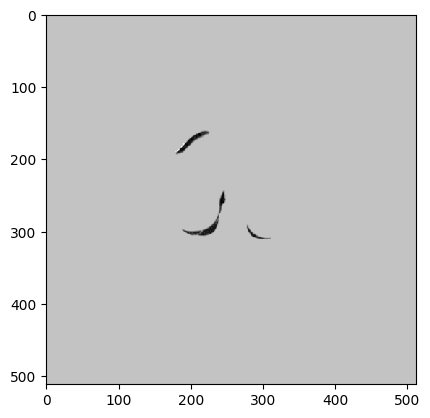

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


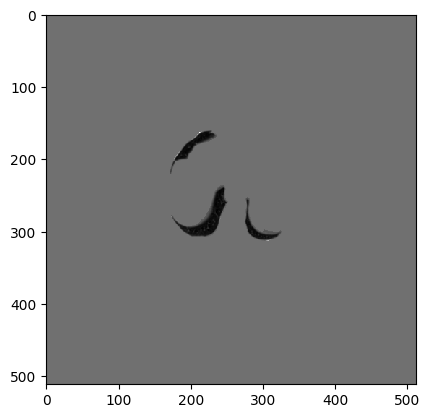

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


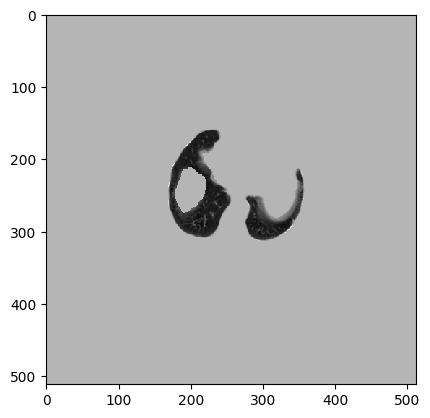

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


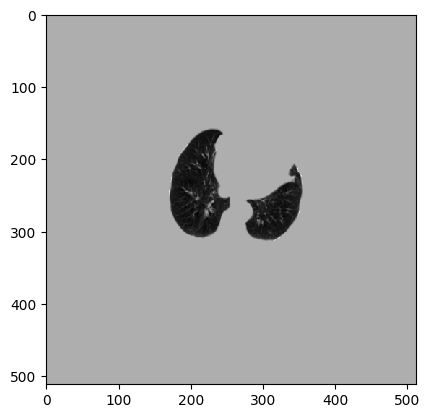

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


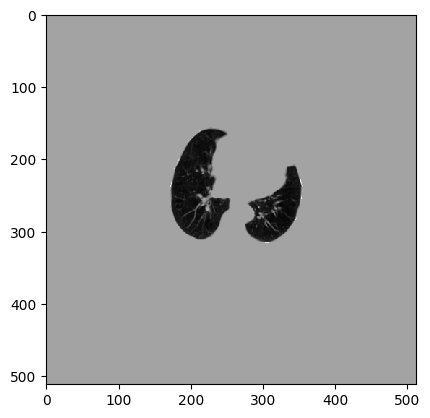

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


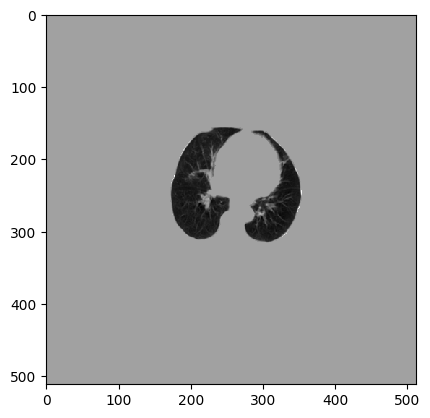

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


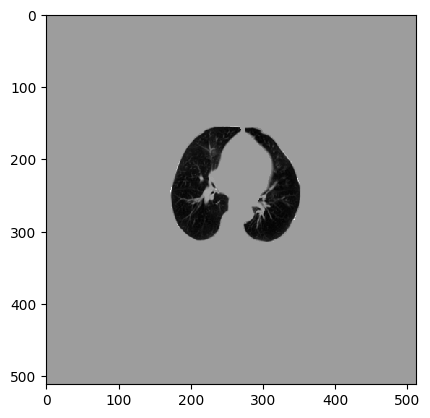

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


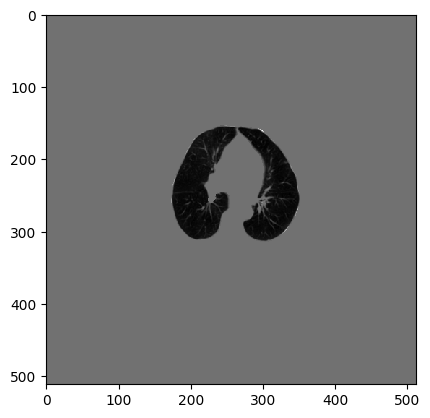

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


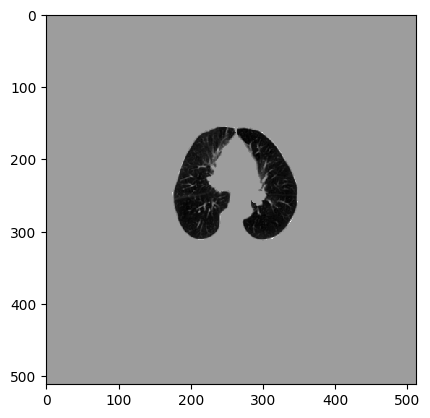

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


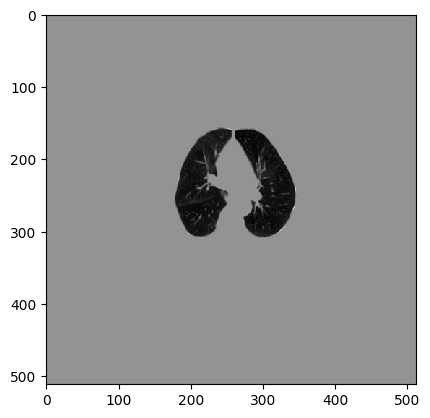

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


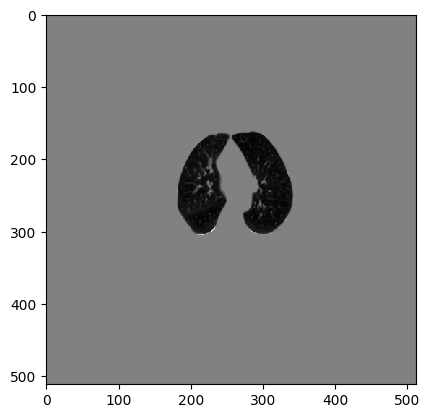

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


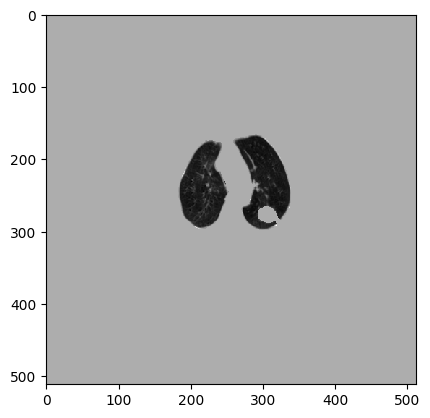

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


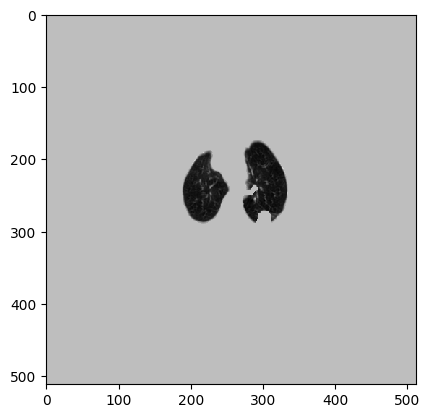

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


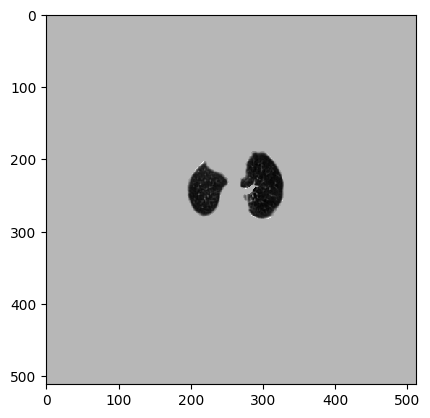

[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]


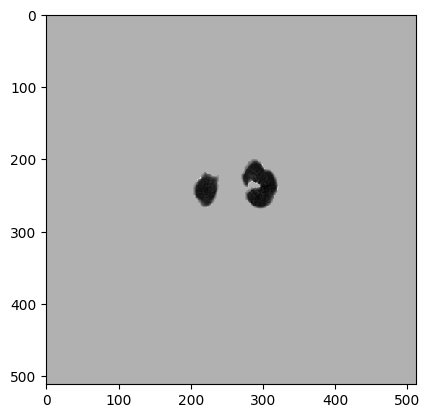

In [14]:
Dicom_path = train_data[3]
Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
Dicom_reader.walk_through_folders(Dicom_path) 
all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

Contour_names = ['lung'] 
associations = [ROIAssociationClass('lung', ['lungs', 'whole lung', 'combo lungs'])]
Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
indexes = Dicom_reader.which_indexes_have_all_rois()
pt_indx = indexes[-1]
Dicom_reader.set_index(pt_indx) 
Dicom_reader.get_images_and_mask()  

image = Dicom_reader.ArrayDicom # image array
mask = Dicom_reader.mask # mask array

slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
slice_start = slice_locations[0] # first slice of contour 
slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

counter = 1

print('shape of image: ', np.shape(image[slice_start:slice_end+1]))
print('shape of mask: ', np.shape(mask[slice_start:slice_end+1]))
print('values found in image: ', np.unique(image[slice_start:slice_end+1]))
print('values found in mask: ', np.unique(mask[slice_start:slice_end+1]))

for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
    if counter % skip == 0: # if current slice is divisible by desired skip amount 
        # mask_indexes = np.where(contour_arr == 0)[0]
        select = np.multiply(img_arr, contour_arr)
        print(select)
        plt.imshow(select, cmap='gray', interpolation='none')
        # img_arr[mask_indexes] = 0
        # plt.imshow(contour_arr, cmap='gray', interpolation='none')
        # masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
        # plt.imshow(img_arr, cmap='gray', interpolation='none')
        # plt.imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.5, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice
        plt.show()
    counter += 1



In [16]:
total_arrays = []
total_labels = []

for i in range(len(train_data)):
    try:
        single_arrays = []
        Dicom_path = train_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [train_labels[i] for x in range(len(single_arrays))]
        total_arrays = total_arrays + single_arrays
        total_labels = total_labels + single_labels
    except TypeError:
        print("skip this dataset")
        continue

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885


Loading through DICOM files: 100%|█| 1/1 [00:12<00:00, 12.51s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 1, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0885. Found []
Contour names or associations changed, resetting mask
The following indexes hav

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050


Loading through DICOM files: 100%|█| 1/1 [00:13<00:00, 13.92s/it


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1050. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192


Loading through DICOM files: 100%|█| 1/1 [00:05<00:00,  5.08s/it


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1192

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210


Loading through DICOM files: 100%|█| 1/1 [00:17<00:00, 17.90s/it


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0210. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670


Loading through DICOM files: 100%|█| 1/1 [00:15<00:00, 15.52s/it


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 4, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0670. Found []
Lacking ['lung'] in index 2, location /home/lam365

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048


Loading through DICOM files: 100%|█| 1/1 [01:15<00:00, 75.78s/it


Compiling dictionaries together...
Index 0, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 4, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1048
Index 8, description 3mm Chest  3.0  B35s at /home/lam365

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163


Loading through DICOM files: 100%|█| 1/1 [00:11<00:00, 11.61s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1163. Found []
Contour n

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069


Loading through DICOM files: 100%|█| 1/1 [00:05<00:00,  5.53s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Index 1, description AXIAL MEDIASTINUM  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1069

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118


Loading through DICOM files: 100%|█| 1/1 [00:01<00:00,  1.89s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1118

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTst_2019-02-16_144510_SBRT.RUL.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTDOSE_2019-02-16_144510_MinIP.SBRT.RUL.Planning_NU.0114_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTPLAN_2019-02-16_144510_MinIP.SBRT.RUL.Planning_NU.0114_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_RTPLAN_2019-02-16_144510_MinIP.SBRT.RUL.Planning_NU.0114_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049510.830.8181.dcm


Loading through DICOM files: 100%|█| 4/4 [00:02<00:00,  1.97it/s


Compiling dictionaries together...
Index 0, description NU_0114  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000
Finished listing present indexes
Loading images for NU_0114  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0114/2019-02__Studies/NU.0114_NU.0114_CT_2019-02-16_144510_SBRT.RUL.Planning_NU.0114_n140__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078


Loading through DICOM files: 100%|█| 1/1 [00:02<00:00,  2.03s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1078

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140


Loading through DICOM files: 100%|█| 1/1 [00:06<00:00,  6.85s/it


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140
Index 1, description THIN AXIALS  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0140

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773


Loading through DICOM files: 100%|█| 1/1 [00:11<00:00, 11.46s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 3, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0773. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198


Loading through DICOM files: 100%|█| 1/1 [00:05<00:00,  5.49s/it


Compiling dictionaries together...
Index 0, description compression; 4D CT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198
Finished listing present indexes
Loading images for compression; 4D CT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0198

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTDOSE_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTst_2016-07-30_083030_SBRT.lung.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTPLAN_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_RTPLAN_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569048698.1055.7021.dcm


Loading through DICOM files: 100%|█| 4/4 [00:03<00:00,  1.29it/s


Compiling dictionaries together...
Index 0, description NU_0035  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000
Finished listing present indexes
Loading images for NU_0035  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0035/2016-07__Studies/NU.0035_NU.0035_CT_2016-07-30_083030_SBRT.lung.planning.bellows_NU.0035_n198__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTPLAN_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTst_2015-12-10_133644_SBRT.Lung.plan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTDOSE_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_RTPLAN_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051644.954.9.dcm


Loading through DICOM files: 100%|█| 4/4 [00:02<00:00,  1.80it/s


Compiling dictionaries together...
Index 0, description NU_0152  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000
Finished listing present indexes
Loading images for NU_0152  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0152/2015-12__Studies/NU.0152_NU.0152_CT_2015-12-10_133644_SBRT.Lung.plan_NU.0152_n155__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117


Loading through DICOM files: 100%|█| 1/1 [00:01<00:00,  1.87s/it


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1117

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139


Loading through DICOM files: 100%|█| 1/1 [00:11<00:00, 11.07s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 1, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 3, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0139. Found []
Contour n

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222


Loading through DICOM files: 100%|█| 1/1 [00:02<00:00,  2.14s/it


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0222

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251


Loading through DICOM files: 100%|█| 1/1 [00:09<00:00,  9.33s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 1, description CHEST W/O SOFT TISSUE  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 2, description CHEST W/ SOFT TISSUE at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 3, description SAGITTAL CHEST at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1251. Found []
Contour names

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072


Loading through DICOM files: 100%|█| 1/1 [00:09<00:00,  9.41s/it


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1072
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820


Loading through DICOM files: 100%|█| 1/1 [00:04<00:00,  4.83s/it


Compiling dictionaries together...
Index 0, description Mean IP: Derived CT 20170620 144342  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820
Finished listing present indexes
Loading images for Mean IP: Derived CT 20170620 144342  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0820

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517


Loading through DICOM files: 100%|█| 1/1 [00:02<00:00,  2.03s/it


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0517

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784


Loading through DICOM files: 100%|█| 1/1 [00:11<00:00, 11.92s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0784. Foun

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834


Loading through DICOM files: 100%|█| 1/1 [00:11<00:00, 11.27s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 1, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 3, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0834. Found []
Contour names or associations changed, rese

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087


Loading through DICOM files: 100%|█| 1/1 [00:01<00:00,  1.77s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1087

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037


Loading through DICOM files: 100%|█| 1/1 [00:05<00:00,  5.21s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1037

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254


Loading through DICOM files: 100%|█| 1/1 [00:02<00:00,  2.00s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1254

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581


Loading through DICOM files: 100%|█| 1/1 [00:08<00:00,  8.66s/it


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0581. Found []
Contour names or associations changed

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962


Loading through DICOM files: 100%|█| 1/1 [00:01<00:00,  1.77s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0962

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262


Loading through DICOM files: 100%|█| 1/1 [00:21<00:00, 21.56s/it


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 3, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 5, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 6, description Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1262
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneum

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742


Loading through DICOM files: 100%|█| 1/1 [00:02<00:00,  2.15s/it


Compiling dictionaries together...
Index 0, description O-MAR  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742
Finished listing present indexes
Loading images for O-MAR  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0742

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257


Loading through DICOM files: 100%|█| 1/1 [00:05<00:00,  5.66s/it


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0257

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177


Loading through DICOM files: 100%|█| 1/1 [00:10<00:00, 10.32s/it


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1177
Finished listing present indexes
Loading images for A

Loading through DICOM files:   0%|        | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055


Loading through DICOM files: 100%|█| 1/1 [00:11<00:00, 11.68s/it


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 3, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1055. Found []
Contour names or associations changed, resetting mask
The follo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.56s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 2, description CHEST W  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 3, description CHESTWO  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 4, description CHEST W  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 5, description CHEST W  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1230. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.44s/it]


Compiling dictionaries together...
Index 0, description O-MAR; 4D CT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0364. Found []
Lacking ['lung'] in index 3, location /hom

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0573

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.19s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1182
Finished listing present indexes
Loading images for A

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0741

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.98s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 1, description OBESE CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 3, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 4, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1064
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneu

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.08s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Index 2, description Axial mediastinum chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0842
Finished listing present 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.26s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0983. Found []
Contour names o

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.93s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0262. Found []
Contour names or associations changed, resettin

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTst_2012-08-28_091754_sbrt.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTPLAN_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTDOSE_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_RTPLAN_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569563285.897.1288.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s]


Compiling dictionaries together...
Index 0, description NU_0107  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000
Finished listing present indexes
Loading images for NU_0107  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0107/2012-08__Studies/NU.0107_NU.0107_CT_2012-08-28_091754_sbrt.planning.bellows_NU.0107_n212__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.37s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 3, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1307. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneum

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1019

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTPLAN_2015-10-13_092441_sbrt.lung.plan_NU.0192_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTDOSE_2015-10-13_092441_sbrt.lung.plan_NU.0192_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTst_2015-10-13_092441_sbrt.lung.plan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_RTPLAN_2015-10-13_092441_sbrt.lung.plan_NU.0192_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053301.758.8969.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


Compiling dictionaries together...
Index 0, description NU_0192  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000
Finished listing present indexes
Loading images for NU_0192  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0192/2015-10__Studies/NU.0192_NU.0192_CT_2015-10-13_092441_sbrt.lung.plan_NU.0192_n144__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1121
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTst_2018-06-21_152956_sbrt.lung.planning.w.contrast_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTDOSE_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTPLAN_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_RTPLAN_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n1__00000/2.16.840.1.114362.1.11940992.24327927514.584242361.

Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.79it/s]


Compiling dictionaries together...
Index 0, description NU_0033  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000
Finished listing present indexes
Loading images for NU_0033  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0033/2018-06__Studies/NU.0033_NU.0033_CT_2018-06-21_152956_sbrt.lung.planning.w.contrast_NU.0033_n135__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.95s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 2, description CHEST  1.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 4, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 6, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 7, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1159
Index 8, description None at None
9 unique series IDs were foun

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.32s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1107
Finished listing present indexes
Loading images for A

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.54s/it]


Compiling dictionaries together...
Index 0, description iDose (3)  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 1, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 2, description Thorax  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0751
Finished listing present indexes
Loading images for iDose (3)  at 
 /home/lam3654/MSAI_pneumonitis/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.94s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Index 1, description Chest   3.0  B35s  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0827
Finished listing present indexes
Loading images for AVG

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.05s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 4, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1183. Found []
Lacking ['lung'] in index 3, location /h

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


Compiling dictionaries together...
Index 0, description AVG CHEST/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0393
Finished listing present indexes
Loading images for AVG CHEST/OncoBody at 
 /home/l

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.73s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 1, description ThorRoutine  3.0  B40f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0753
Finished listing present indexes
Load

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.51s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141. Found ['wall of ptv (free+rtog)', 'free breathing gtv', 'outer contour', 'ptv (free+rtog)', 'exhale gtv', 'inhale gtv', 'brachial plexus', 'proximal bronchial tree', 'trachea', 'left lung', 'heart', 'esophagus', 'spinal cord']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1141. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumoni

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1070

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTPLAN_2011-03-19_114119_SBRT.planning_NU.0097_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTst_2011-03-19_114119_SBRT.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTDOSE_2011-03-19_114119_SBRT.planning_NU.0097_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_RTPLAN_2011-03-19_114119_SBRT.planning_NU.0097_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055542.682.3868.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.07it/s]


Compiling dictionaries together...
Index 0, description NU_0097  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000
Finished listing present indexes
Loading images for NU_0097  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0097/2011-03__Studies/NU.0097_NU.0097_CT_2011-03-19_114119_SBRT.planning_NU.0097_n117__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.13s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 3, description CHEST w/o  5.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1161. Found []
Contour nam

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.06s/it]


Compiling dictionaries together...
Index 0, description abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0320. Found ['esophagus', 'gtv in', 'gtv ex', 'gtv 1st gtv exhale union', 'gtv 1st', 'outer contour', 'rt lung', 'cord', 'heart', 'itv', 'ptv', 'trachea', 'pbt', 'esophagus wall', 'airway', 'airway wall', 'new right lung']
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumo

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1287. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.21s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0312
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumon

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.90s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 2, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 3, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0202. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MS

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTPLAN_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTst_2018-12-01_145941_SBRT.Chest.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTDOSE_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_RTPLAN_2018-12-01_145941_MinIP.SBRT.Chest.planning_NU.0063_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052301.996.1566.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.39it/s]


Compiling dictionaries together...
Index 0, description NU_0063  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000
Finished listing present indexes
Loading images for NU_0063  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0063/2018-12__Studies/NU.0063_NU.0063_CT_2018-12-01_145941_SBRT.Chest.planning_NU.0063_n164__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.08s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0985. Found []
C

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTDOSE_2011-10-25_103304_SBRT.Lung.Bellow.Re-Scan_NU.0128_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTPLAN_2011-10-25_103304_SBRT.Lung.Bellow.Re-Scan_NU.0128_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTst_2011-10-25_103304_SBRT.Lung.Planning_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_RTPLAN_2011-10-25_103304_SBRT.Lung.Bellow.Re-Scan_NU.0128_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055275.578.5843.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.64it/s]


Compiling dictionaries together...
Index 0, description NU_0128  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000
Finished listing present indexes
Loading images for NU_0128  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0128/2011-10__Studies/NU.0128_NU.0128_CT_2011-10-25_103304_SBRT.Lung.Planning_NU.0128_n148__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.28s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0260. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0589

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.78it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTst_2018-07-10_145219_SBRT.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTDOSE_2018-07-10_145219_SBRT.planning_NU.0020_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTPLAN_2018-07-10_145219_SBRT.planning_NU.0020_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_RTPLAN_2018-07-10_145219_SBRT.planning_NU.0020_n1__00000/2.16.840.1.114362.1.11940992.24327927514.584242176.1086.1008.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s]


Compiling dictionaries together...
Index 0, description NU_0020  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000
Finished listing present indexes
Loading images for NU_0020  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0020/2018-07__Studies/NU.0020_NU.0020_CT_2018-07-10_145219_SBRT.planning_NU.0020_n156__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.64s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0993

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.45s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745
Finished listing present indexes
Loading images for AIP 0,10,20,30,40,50,60,70,80,90%  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0745

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 12.00s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1249. Found []
Contour names or associations changed, resetting 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTst_2010-03-23_104049_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTPLAN_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTDOSE_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_RTPLAN_2010-03-23_104049_SBRT.Iso.Placement_NU.0196_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051033.962.694.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.27it/s]


Compiling dictionaries together...
Index 0, description NU_0196  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000
Finished listing present indexes
Loading images for NU_0196  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0196/2010-03__Studies/NU.0196_NU.0196_CT_2010-03-23_104049_SBRT.Lung.Planning_NU.0196_n177__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.28s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1031. Found []
Lacking ['lung

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.69s/it]


Compiling dictionaries together...
Index 0, description AVG 10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1016. Found []
Lacking [

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.67s/it]


Compiling dictionaries together...
Index 0, description O-MAR; omar; 4D CT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 2, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 5, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 6, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1210
Index 8, description Thorax  3.0  B31f  at /home/la

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.98s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0672. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.64s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1133. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumon

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.31s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0695. Found []
Contour names or associations changed, resettin

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1059

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.98s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0992
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1203. Found ['iso lul', 'cord', 'esophagus', 'external', 'gtv free', 'heart', 'ipsi bp', 'itv', 'lung_l', 'pbt', 'ptv', 'trachea', 'ptv_2cm', '1', 'ptv 3mm']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.04s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0149
Index 8, description 3MMCHEST  3.0  B35f  at /home/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.04s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0634

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1020

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1036


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1036
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1036. Found ['iso', 'gtv free', 'r lung', 'l lung', 'trachea', 'pbt', 'cord', 'heart', 'gtv inhale (not used)', 'gtv exhale', 'itv', 'ptv', 'ipsi bp', 'timmermans trick', 'esophagus', 'total lung - itv', 'ring', 'table tx', 'ipsi bp prv']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.66s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 1, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 3, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1046. Found []
Contour names or associations changed, resett

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.84s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 1, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 2, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 3, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 4, description Thorax  3.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 5, description PE CHEST  1.0  B30f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0054. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneu

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 18.92it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTPLAN_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTst_2018-10-18_141613_SBRT.Lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTDOSE_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_RTPLAN_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569048131.123.8231.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


Compiling dictionaries together...
Index 0, description NU_0177  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000
Finished listing present indexes
Loading images for NU_0177  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0177/2018-10__Studies/NU.0177_NU.0177_CT_2018-10-18_141613_SBRT.Lung.planning_NU.0177_n157__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTPLAN_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTDOSE_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTst_2012-07-29_091844_SBRT.planning..bellows_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_RTPLAN_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053011.150.589.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.56it/s]


Compiling dictionaries together...
Index 0, description NU_0119  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000
Finished listing present indexes
Loading images for NU_0119  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0119/2012-07__Studies/NU.0119_NU.0119_CT_2012-07-29_091844_SBRT.planning..bellows_NU.0119_n203__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.01s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0948. Found []
Contour names o

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.32s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 4, description Chest   3.0  B35s  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 5, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0003. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSA

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Compiling dictionaries together...
Index 0, description CHEST 3MM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0681

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.93it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTPLAN_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTDOSE_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTst_2010-11-28_101205_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_RTPLAN_2010-11-28_101205_SBRT.ISO.placemant_NU.0163_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569049584.1068.2998.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.12it/s]


Compiling dictionaries together...
Index 0, description NU_0163  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000
Finished listing present indexes
Loading images for NU_0163  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0163/2010-11__Studies/NU.0163_NU.0163_CT_2010-11-28_101205_SBRT.Lung.Planning_NU.0163_n242__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.25s/it]


Compiling dictionaries together...
Index 0, description ABC1; abc 1; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 5, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 6, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0504
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pne

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.13s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
Index 5, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0968. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.88s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 2, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0468
Finished listing present indexes
Loading images for A

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Compiling dictionaries together...
Index 0, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576
Index 1, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0576

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.99s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0102

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.92s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0971

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.65s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 1, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1093. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Index 1, description AXIAL MEDIASTINUM  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1012

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:53<00:00, 53.41s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 2, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 3, description CT WB_AC  5.0  B31f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 5, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1238
Index 8, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/d

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0704

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.31s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0158. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Compiling dictionaries together...
Index 0, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065
Finished listing present indexes
Loading images for AVG BODY/OncoBody  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1065

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0862

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.26s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 1, description Chest 3mm  3.0  B35f s.t.  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 2, description Chest 3mm  3.0  B35f s.t.  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 3, description Chest 3mm  3.0  B35f s.t.  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1190. 

Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.69it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTPLAN_2018-08-07_111010_MInIP.SBRT.Lung.Planning_NU.0028_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTst_2018-08-07_111010_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTDOSE_2018-08-07_111010_MInIP.SBRT.Lung.Planning_NU.0028_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_RTPLAN_2018-08-07_111010_MInIP.SBRT.Lung.Planning_NU.0028_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569053332.327.1295.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s]


Compiling dictionaries together...
Index 0, description NU_0028  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000
Finished listing present indexes
Loading images for NU_0028  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0028/2018-08__Studies/NU.0028_NU.0028_CT_2018-08-07_111010_SBRT.Lung.Planning_NU.0028_n177__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0612
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumon

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0636

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.54s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 4, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196
Index 5, description None at None
6 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1196. Found []
Lacking ['lung'] in index 3, location /home/lam365

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0865

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTst_2013-05-11_090408_Lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTPLAN_2013-05-11_090408_Lung.planning_NU.0215_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTDOSE_2013-05-11_090408_Lung.planning_NU.0215_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_RTPLAN_2013-05-11_090408_Lung.planning_NU.0215_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052169.306.7477.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.54it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Compiling dictionaries together...
Index 0, description NU_0215  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.0215_n185__00000
Finished listing present indexes
Loading images for NU_0215  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0215/2013-05__Studies/NU.0215_NU.0215_CT_2013-05-11_090408_Lung.planning_NU.02

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.37s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 7, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0616
Index 8, description None at None
9 unique series IDs w

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.18s/it]


Compiling dictionaries together...
Index 0, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 2, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1316
Finished listing present indexes
Loading images for AVG 0

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.71s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 1, description Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 3, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 5, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 6, description Axial mediastinum OBESE CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1270
Index 7, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/tr

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 1, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 3, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 4, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 5, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0887
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/dat

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  2.00s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1097

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.17s/it]


Compiling dictionaries together...
Index 0, description AIP 0,10,20,30,40,50,60,70,80,90%  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Index 1, description Axial mediastinum Chest   3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Index 2, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0835
Finished listing present indexes
Loading 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.04s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 1, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 2, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 3, description ThorRoutine  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0859. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTst_2018-07-11_125322_sbrt.lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTDOSE_2018-07-11_125322_sbrt.lung.planning_._n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTPLAN_2018-07-11_125322_sbrt.lung.planning_._n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_RTPLAN_2018-07-11_125322_sbrt.lung.planning_._n1__00000/2.16.840.1.114362.1.11940992.24327927514.584241430.895.839.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0018/2018-07__Studies/NU.0018_NU.0018_CT_2018-07-11_125322_sbrt.lung.planning_._n151__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.30s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 1, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 4, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1108. Found []
Lacking

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.09s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Index 2, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0444
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneum

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.45s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 6, description 3MM CHEST  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
Index 7, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0959
8 unique series IDs were found. Def

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.16s/it]


Compiling dictionaries together...
Index 0, description AVG CHEST/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 2, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 3, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554
Index 4, description None at None
5 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554. Found []
Lacking ['lung'] in index 3, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0554. Found []
Contour names or associations changed, rese

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.10s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1266

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTPLAN_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTDOSE_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTst_2010-06-01_110608_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_RTPLAN_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051119.648.6026.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s]


Compiling dictionaries together...
Index 0, description NU_0115  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000
Finished listing present indexes
Loading images for NU_0115  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0115/2010-06__Studies/NU.0115_NU.0115_CT_2010-06-01_110608_SBRT.Lung.Planning_NU.0115_n214__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.86s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 3, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 4, description Chest 3mm  3.0  B30f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 5, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 6, description AXIAL MEDIASTINUM  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P1060
Index 7, description None at None
8 unique series IDs were found. Default is index 0, to change use set_index(ind

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.65s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 6, description CHEST 1MM  1.0  B31f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 7, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0643
Index 8, description None at None
9 unique series IDs were 

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1104

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0472

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0805

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Compiling dictionaries together...
Index 0, description iDose (3)  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877
Index 1, description Axial Mediastinum CHEST 3MM  3.0  Qr36 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877
Finished listing present indexes
Loading images for iDose (3)  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0877

Erasing any previous mask as we load a new new image set


In [17]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

In [29]:
np.save(os.path.join(np_folder_path, "train_arrays.npy"), total_arrays)

with open(os.path.join(np_folder_path, "train_labels_np.json"), "w") as file:
    json.dump(total_labels, file)

#### Build dataset

In [37]:
class CTDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]
        return image, label

In [30]:
loaded_array_list = np.load(os.path.join(np_folder_path, "train_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "train_labels_np.json"), "r") as file:
    train_labels_list = json.load(file)

In [69]:
print(sum(train_labels_list))
print(len(train_labels_list))
print(722/(2649))
print(2649/4)


722
2649
0.2725556813892035
662.25


In [42]:
print(loaded_array_list[0].shape)

(512, 512)


In [38]:
dataset = CTDataset(loaded_array_list, train_labels_list)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [67]:
print(len(data_loader))

663


## Define model structure

In [59]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 128 * 128, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 128 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Train model

In [70]:
# Check if a GPU is available and if not, default to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Initialize the model, loss function, and optimizer
model = CNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

output_list = []
num_epochs = 10 
for epoch in range(num_epochs):
    image_count = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        images = images[:, np.newaxis, :, :]
        images = images.float()

        # Forward pass
        outputs = model(images)
        output_list.append(outputs)
        loss = criterion(outputs, labels)
        _, predicted = outputs.max(1)
        print(f"Batch {image_count+1} predictions: {predicted.tolist()}")
        image_count += 1
        # Backward and optimize
        loss.backward()
        optimizer.step()
    print('number of images: ', image_count)
    # Print the loss after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


# Save the model
model_save_path = "./model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Training on cuda:0
Batch 1 predictions: [1, 1, 0, 1]
Batch 2 predictions: [0, 0, 0, 0]
Batch 3 predictions: [0, 0, 0, 0]
Batch 4 predictions: [0, 0, 0, 0]
Batch 5 predictions: [1, 0, 1, 0]
Batch 6 predictions: [1, 0, 1, 1]
Batch 7 predictions: [0, 1, 0, 1]
Batch 8 predictions: [1, 0, 1, 1]
Batch 9 predictions: [0, 1, 1, 1]
Batch 10 predictions: [0, 1, 1, 0]
Batch 11 predictions: [1, 0, 0, 1]
Batch 12 predictions: [0, 0, 1, 0]
Batch 13 predictions: [0, 0, 0, 0]
Batch 14 predictions: [0, 0, 1, 1]
Batch 15 predictions: [0, 0, 0, 0]
Batch 16 predictions: [0, 0, 0, 0]
Batch 17 predictions: [0, 0, 0, 0]
Batch 18 predictions: [0, 0, 0, 0]
Batch 19 predictions: [0, 0, 0, 0]
Batch 20 predictions: [0, 0, 0, 0]
Batch 21 predictions: [0, 0, 0, 0]
Batch 22 predictions: [0, 0, 0, 0]
Batch 23 predictions: [0, 0, 0, 0]
Batch 24 predictions: [0, 0, 0, 0]
Batch 25 predictions: [0, 0, 0, 0]
Batch 26 predictions: [0, 0, 1, 0]
Batch 27 predictions: [0, 0, 0, 0]
Batch 28 predictions: [0, 0, 0, 0]
Batch 29 p

In [ ]:
model_path = '/home/lam3654/MSAI_pneumonitis/lung_cancer_radiomics/first_model.pt'
torch.save(model.state_dict(), model_path)

## Test model

### Open test list files

In [73]:
with open(os.path.join(path, "test_data.json"), "r") as file:
    test_data = json.load(file)

with open(os.path.join(path, "test_labels.json"), "r") as file:
    test_labels = json.load(file)

### Get Numpy arrays

In [74]:
total_test_arrays = []
total_test_labels = []

for i in range(len(test_data)):
    try:
        single_arrays = []
        Dicom_path = test_data[i]
        Dicom_reader = DicomReaderWriter(description='Examples', arg_max=True)
        Dicom_reader.walk_through_folders(Dicom_path) 
        # all_rois = Dicom_reader.return_rois(print_rois=True) # Return a list of all rois present

        Contour_names = ['lung'] 
        associations = [ROIAssociationClass('lung', lung_list)]
        Dicom_reader.set_contour_names_and_associations(contour_names=Contour_names, associations=associations)
        indexes = Dicom_reader.which_indexes_have_all_rois()
        if indexes != []:
            pt_indx = indexes[-1]
            Dicom_reader.set_index(pt_indx) 
            Dicom_reader.get_images_and_mask()  

            image = Dicom_reader.ArrayDicom # image array
            mask = Dicom_reader.mask # mask array

            slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
            slice_start = slice_locations[0] # first slice of contour 
            slice_end = slice_locations[len(slice_locations)-1] # last slice of contour

            counter = 1

            for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): 
                if counter % skip == 0: # if current slice is divisible by desired skip amount 
                    select = np.multiply(img_arr, contour_arr)
                    single_arrays.append(select)
                counter += 1
        single_labels = [test_labels[i] for x in range(len(single_arrays))]
        total_test_arrays = total_test_arrays + single_arrays
        total_test_labels = total_test_labels + single_labels
    except TypeError:
        print("skip this dataset")
        continue

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTPLAN_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTst_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTDOSE_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_RTPLAN_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569051384.715.5526.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.32it/s]


Compiling dictionaries together...
Index 0, description NU_0134  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000
Finished listing present indexes
Loading images for NU_0134  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0134/2017-08__Studies/NU.0134_NU.0134_CT_2017-08-19_144247_SBRT.LUL.Plan.and.Bellows_NU.0134_n170__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0315


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0315
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0315. Found ['trach', 'heart', 'right lung', '4d gtv', 'wall of ptv', 'pen', 'eso', 'ptv (gtv+5mm)', 'pen2', 'outer contour', 'prox bronch', 'b plex', 'cord']
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Finished listing present indexes


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTst_2016-10-18_110429_SBRT.Lung_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTPLAN_2016-10-18_110429_SBRT.Lung_NU.0077_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTDOSE_2016-10-18_110429_SBRT.Lung_NU.0077_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_RTPLAN_2016-10-18_110429_SBRT.Lung_NU.0077_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569047963.1085.987.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.33it/s]


Compiling dictionaries together...
Index 0, description NU_0077  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000
Finished listing present indexes
Loading images for NU_0077  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0077/2016-10__Studies/NU.0077_NU.0077_CT_2016-10-18_110429_SBRT.Lung_NU.0077_n145__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  50%|███████████████████████████████████                                   | 2/4 [00:00<00:00, 19.57it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTDOSE_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTst_2017-12-09_103636_sbrt.lung.planning.bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTPLAN_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_RTPLAN_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569056052.731.494.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.25it/s]


Compiling dictionaries together...
Index 0, description NU_0147  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000
Finished listing present indexes
Loading images for NU_0147  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0147/2017-12__Studies/NU.0147_NU.0147_CT_2017-12-09_103636_sbrt.lung.planning.bellows_NU.0147_n148__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.21s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 6, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 7, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0570
Index 8, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 2, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560. Found []
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 2, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0560
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 1, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 2, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 3, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 4, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 5, description CHEST WITHOUT  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1073. Found []
Lacking ['lung'] in index 2, location /home/lam3654/M

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.54s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 1, description Chest 3mm  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 4, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 6, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Index 7, description Axial Mediastinum Chest  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1269
Ind

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.58s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 2, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 3, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 5, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0571. Found []
Lacking ['lung'] in index 2, location /home/lam36

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.62s/it]


Compiling dictionaries together...
Index 0, description NEW 4DCT/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Index 3, description None at None
4 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1106
Finished listing present indexes
Loading images for NEW 4DCT/OncoBody  at 
 /home/lam36

Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.81s/it]


Compiling dictionaries together...
Index 0, description AVG CHEST/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047
Index 1, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047
Finished listing present indexes
Loading images for AVG CHEST/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0047

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTst_2017-06-21_133754_SBRT.Lung.Planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTDOSE_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTPLAN_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_RTPLAN_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569057273.485.6515.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.47it/s]


Compiling dictionaries together...
Index 0, description NU_0084  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000
Finished listing present indexes
Loading images for NU_0084  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0084/2017-06__Studies/NU.0084_NU.0084_CT_2017-06-21_133754_SBRT.Lung.Planning_NU.0084_n188__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTPLAN_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTDOSE_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTst_2012-05-20_143510_SBRT.Lung.planning.scan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_RTPLAN_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055783.1031.6736.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.60it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Compiling dictionaries together...
Index 0, description NU_0235  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05-20_143510_SBRT.Lung.planning.scan_NU.0235_n184__00000
Finished listing present indexes
Loading images for NU_0235  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0235/2012-05__Studies/NU.0235_NU.0235_CT_2012-05

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0668

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.03s/it]


Compiling dictionaries together...
Index 0, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 1, description ThoraxRoutine 5.0 B40s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 3, description PE_STUDY  1.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 4, description Aligned CT 100503 14:28,; fusion 1 and 2 YW; AVG BODY/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0113. Found []
Lac

Loading through DICOM files:  25%|█████████████████▌                                                    | 1/4 [00:00<00:00,  9.48it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTPLAN_2013-02-08_150300_._NU.0199_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTDOSE_2013-02-08_150300_._NU.0199_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTst_2013-02-08_150300_SBRT.RLung.planning.scan_AY_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_RTPLAN_2013-02-08_150300_._NU.0199_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569055756.363.5066.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


Compiling dictionaries together...
Index 0, description NU_0199  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000
Finished listing present indexes
Loading images for NU_0199  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0199/2013-02__Studies/NU.0199_NU.0199_CT_2013-02-08_150300_SBRT.RLung.planning.scan_NU.0199_n211__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0874

Erasing any previous mask as we load a new new image set


Loading through DICOM files:  25%|█████████████████▌                                                    | 1/4 [00:00<00:00,  9.61it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTPLAN_2013-03-16_085903_SBRT.Scout_NU.0094_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTst_2013-03-16_085903_SBRT.Scout_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTDOSE_2013-03-16_085903_SBRT.Scout_NU.0094_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_RTPLAN_2013-03-16_085903_SBRT.Scout_NU.0094_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052648.127.5200.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]


Compiling dictionaries together...
Index 0, description NU_0094  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000
Finished listing present indexes
Loading images for NU_0094  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0094/2013-03__Studies/NU.0094_NU.0094_CT_2013-03-16_085903_SBRT.Scout_NU.0094_n217__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


Compiling dictionaries together...
Index 0, description CHEST  3.0  B35f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 2, description 3MMCHEST  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 3, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 4, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 5, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 6, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 7, description CHEST W/O  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 8, description AVG BODY/OncoBody  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0663
Index 9

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTDOSE_2011-09-23_091338_SBRT.Lung.Iso.Scan_NU.0110_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTst_2011-09-23_091338_SBRT.Lung.Planning..Bellows_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTPLAN_2011-09-23_091338_SBRT.Lung.Iso.Scan_NU.0110_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_RTPLAN_2011-09-23_091338_SBRT.Lung.Iso.Scan_NU.0110_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052143.208.6190.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.41it/s]


Compiling dictionaries together...
Index 0, description NU_0110  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000
Finished listing present indexes
Loading images for NU_0110  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0110/2011-09__Studies/NU.0110_NU.0110_CT_2011-09-23_091338_SBRT.Lung.Planning..Bellows_NU.0110_n187__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.94s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 3, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 5, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 6, description THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
Index 7, description Axial mediastinum THORAX  3.0  B35f  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0964
8 unique 

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTst_2017-08-01_093310_SBRT.Lung_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTPLAN_2017-08-01_093310_SBRT.Lung_._n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTDOSE_2017-08-01_093310_SBRT.Lung_._n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_RTPLAN_2017-08-01_093310_SBRT.Lung_._n1__00000/2.16.840.1.114362.1.12046989.24327927514.609546435.590.354.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.07it/s]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000
Finished listing present indexes
Loading images for  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0239/2017-08__Studies/NU.0239_NU.0239_CT_2017-08-01_093310_SBRT.Lung_._n215__00000

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290
1 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1290

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.96s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P1132

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.51s/it]


Compiling dictionaries together...
Index 0, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0500

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.17s/it]


Compiling dictionaries together...
Index 0, description AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Index 1, description CHEST  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356
Finished listing present indexes
Loading images for AVG 0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0 at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/P0356

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTst_2016-10-23_083956_SBRT.Lung.planning_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTPLAN_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTDOSE_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_RTPLAN_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569050559.591.6504.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.01it/s]

failed on /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Compiling dictionaries together...
Index 0, description NU_0228  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT.Lung.planning_NU.0228_n118__00000
Finished listing present indexes
Loading images for NU_0228  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/NU_0228/2016-10__Studies/NU.0228_NU.0228_CT_2016-10-23_083956_SBRT


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Compiling dictionaries together...
Index 0, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715
Index 1, description 4D CT/OncoBody at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715
Index 2, description None at None
3 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 0, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715. Found []
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 1, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715
Finished listing present indexes
Loading images for 4D CT/OncoBody at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0715

Erasing any previous mask as we load a new new image set


Loading through DICOM files:   0%|                                                                              | 0/1 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.34s/it]


Compiling dictionaries together...
Index 0, description  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 1, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 2, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 3, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 4, description 3mm Chest  3.0  B35s at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 5, description ThorRoutine  3.0  B41f at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677
Index 6, description None at None
7 unique series IDs were found. Default is index 0, to change use set_index(index)
Lacking ['lung'] in index 1, location /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_negative/P0677. Found []
Lacking ['lung'] in index 2, location /home/lam3654/MSAI_pneumoni

Loading through DICOM files:   0%|                                                                              | 0/4 [00:00<?, ?it/s]

Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTDOSE_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTst_2012-09-23_092750_SBRT.Lung.Plan_AY_n1__00000
Loading from /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTPLAN_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000
Had an error loading /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_RTPLAN_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n1__00000/2.16.840.1.114362.1.11940992.22933840372.569052816.114.2423.dcm


Loading through DICOM files: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.33it/s]


Compiling dictionaries together...
Index 0, description NU_0062  at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Index 1, description None at None
2 unique series IDs were found. Default is index 0, to change use set_index(index)
Contour names or associations changed, resetting mask
The following indexes have all ROIs present
Index 0, located at /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000
Finished listing present indexes
Loading images for NU_0062  at 
 /home/lam3654/MSAI_pneumonitis/data/train/pneumonitis_positive/NU_0062/2012-09__Studies/NU.0062_NU.0062_CT_2012-09-23_092750_SBRT.Lung.Plan_NU.0062_n175__00000

Erasing any previous mask as we load a new new image set


### Save numpy data lists

In [ ]:
np_folder_path = '/home/lam3654/MSAI_pneumonitis/data/pneumonitis_np'

In [75]:
np.save(os.path.join(np_folder_path, "test_arrays.npy"), total_test_arrays)


with open(os.path.join(np_folder_path, "test_labels_np.json"), "w") as file:
    json.dump(total_test_labels, file)

### Build test dataset

In [80]:
test_array_list = np.load(os.path.join(np_folder_path, "test_arrays.npy"), allow_pickle=True)

with open(os.path.join(np_folder_path, "test_labels_np.json"), "r") as file:
    test_labels_list = json.load(file)

In [77]:
print(len(test_array_list))

626


In [81]:
test_dataset = CTDataset(test_array_list, test_labels_list)
test_data_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

### Run Testing

In [83]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 6.7 MB/s eta 0:00:000:00:01


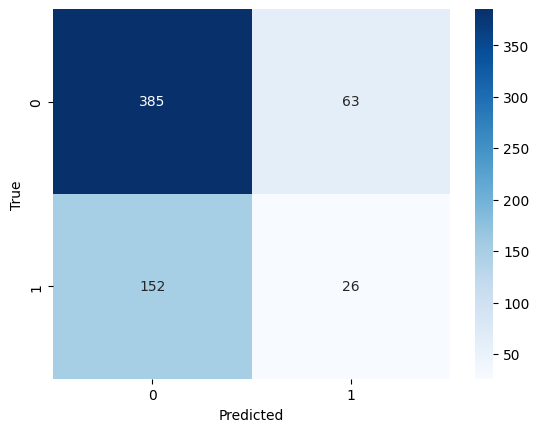

Accuracy: 0.6565495207667732
ROC AUC: 0.5027212078651685


In [86]:
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

model.eval()  # Set the model to evaluation mode

true_labels = []
pred_labels = []
outputs_list = []

# Loop through the test data
for inputs, labels in test_data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs[:, np.newaxis, :, :]
    inputs = inputs.float()


    # Forward pass
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)  # Get the predicted classes

    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(preds.cpu().numpy())
    outputs_list.extend(outputs.detach().cpu().numpy())

# Convert to numpy arrays for use with sklearn
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Compute ROC AUC
roc_auc = roc_auc_score(label_binarize(true_labels, classes=[0,1]),
                        label_binarize(pred_labels, classes=[0,1]), 
                        average='macro')

# Compute accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")
